In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import optim, nn
from torchvision import transforms as T, models
from torchvision.utils import make_grid

from gan.dcgan import DCGan, DCGanConfig

from utils.benchmark import PerceptualLoss, train, test
from utils.checkpoints import save_checkpoint, load_checkpoint
from utils.display import display_images
from __datasets__ import CelebADataset

In [20]:
config = DCGanConfig(
    "../../pytorch/datasets/celeb-a",
    "dcgan_celeb_a",
    inp_features=128,
    out_features=3,
    latent_features=64,
    blocks=(64, 128, 256, 512),
    downsample=4,
    residuals=9,
    n=0,
    p=0,
    lr=3e-4,
    betas=(0.5, 0.999),
    lambda_perceptual=1,
)

In [21]:
ds = CelebADataset(
    DIR=config.dataset_path,
    download=True,
    sub_sample=0.1,
    image_transform=T.Compose([
        T.ToTensor(),
        T.Resize((128, 128), antialias=True),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        lambda x: x.to(config.device),
    ]),
)
len(ds), ds[0]["image"].shape, ds[0]["image"].device

(20259, torch.Size([3, 128, 128]), device(type='mps', index=0))

In [22]:
dcgan = DCGan(config).to(config.device)
dcgan

DCGan(
  (generator): DCGanGenerator(
    (head): Sequential(
      (0): LinearBlock(
        (0): Linear(in_features=128, out_features=4096, bias=True)
        (1): ReLU()
      )
      (1): Unflatten(dim=1, unflattened_size=(64, 8, 8))
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ResidualConvBlock(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (shortcut): Identity()
        )
        (1): ResidualConvBlock(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (shortcut): Identity()
        )
        (2): ResidualConvBlock(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1

In [23]:
optimizerD = optim.Adam(dcgan.D.parameters(), lr=config.lr, betas=config.betas)
optimizerG = optim.Adam(dcgan.G.parameters(), lr=config.lr, betas=config.betas)
writer = config.writer
criterion = nn.MSELoss()
perceptual_loss = PerceptualLoss(
    models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:29].eval().to(config.device)
)
lambda_perceptual = config.lambda_perceptual

def train_step(DATA, step):
    real = DATA["image"]
    fake = dcgan.G(torch.randn(real.shape[0], config.inp_features, device=config.device))
    real_pred = dcgan.D(real)

    # === Discriminator Loss ===
    # adversarial Loss
    fake_pred = dcgan.D(fake.detach())
    lossD_adv = criterion(real_pred, torch.ones_like(real_pred)) + criterion(fake_pred, torch.zeros_like(fake_pred))
    # total Loss
    loss_D = lossD_adv
    # backprop
    optimizerD.zero_grad()
    loss_D.backward()
    optimizerD.step()
    # --- End Discriminator Loss ---
    
    # === Generator Loss ===
    # adversarial Loss
    fake_pred = dcgan.D(fake)
    lossG_adv = criterion(fake_pred, torch.ones_like(fake_pred))
    # perceptual Loss
    loss_perceptual = perceptual_loss(fake, real) if perceptual_loss else torch.tensor(0)
    # total Loss
    loss_G = lossG_adv + lambda_perceptual * loss_perceptual
    # backprop
    optimizerG.zero_grad()
    loss_G.backward()
    optimizerG.step()
    # --- End Generator Loss ---
    
    # === Logging ===
    if writer:
        writer.add_scalar("loss/loss_D", loss_D.item(), step)
        writer.add_scalar("loss/loss_G", loss_G.item(), step)
        writer.add_scalar("loss/lossD_adv", lossD_adv.item(), step)
        writer.add_scalar("loss/lossG_adv", lossG_adv.item(), step)
        writer.add_scalar("loss/loss_perceptual", loss_perceptual.item(), step)
        writer.add_scalar("pred/real_pred", real_pred.mean().item(), step)
        writer.add_scalar("pred/fake_pred", fake_pred.mean().item(), step)
        writer.add_images("real", real, step)
        writer.add_images("fake", fake, step)
    # --- End Logging ---
    
    # === Checkpoint ===
    # --- End Checkpoint ---
    
    return {
        "loss/gen": loss_G.item(),
        "loss/dis": loss_D.item(),
        "loss/adv_gen": lossG_adv.item(),
        "loss/adv_dis": lossD_adv.item(),
        "loss/perceptual": loss_perceptual.item(),
        "pred/real_pred": real_pred.mean().item(),
        "pred/fake_pred": fake_pred.mean().item(),
    }

In [35]:
train(
    train_step,
    ds,
    ne=1, bs=config.batch_size,
    step_offset=0,
)

Epoch: 0/1 | Batch 0/634|          |  0% [00:00<?, ?it/s , loss=?]

KeyboardInterrupt: 

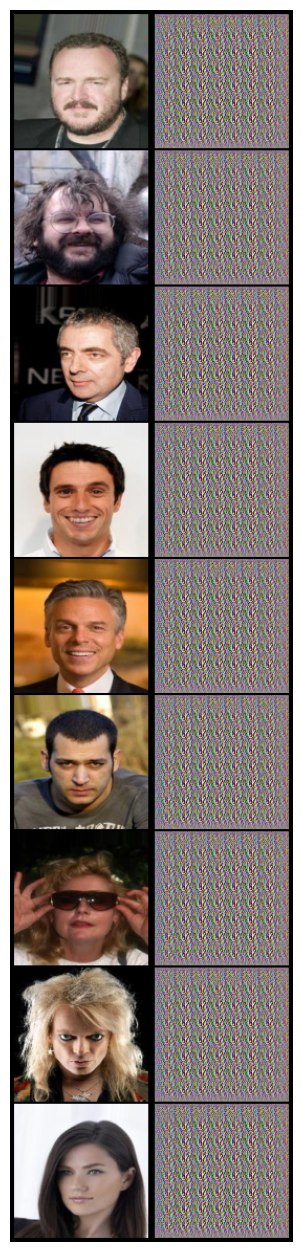

CPU times: user 436 ms, sys: 84.8 ms, total: 520 ms
Wall time: 286 ms


In [36]:
%%time

dcgan = dcgan.eval()
fixed = ds[0:9]["image"]
with torch.inference_mode():
    grid_real = make_grid(fixed, nrow=1, normalize=True)
    grid_fake = make_grid(fake := dcgan.G(torch.randn(len(fixed), config.inp_features, device=config.device)), nrow=1, normalize=True)
    # grid_double = make_grid(double := dcgan.G(fake), nrow=1, normalize=True)
    grid = make_grid([grid_real, grid_fake], nrow=2, normalize=True)
display_images([grid.cpu().permute(1, 2, 0)])